In [1]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
from sklearn.utils import resample
import mne
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import pearsonr
from sklearn.neighbors import NearestCentroid as NCC
from sklearn.linear_model import LogisticRegression

### Data Analysis Part

In [30]:
data_path = 'dataset/train'
label_path = 'dataset/TrainLabels.csv'

# List of EEG session files
session_files = sorted(os.listdir(data_path))
print(f"Total EEG sessions: {len(session_files)}")

# Load labels
labels_df = pd.read_csv(label_path)
print(labels_df.head())
print(f"Total labels: {labels_df.shape[0]}")

Total EEG sessions: 80
         IdFeedBack  Prediction
0  S02_Sess01_FB001           1
1  S02_Sess01_FB002           1
2  S02_Sess01_FB003           0
3  S02_Sess01_FB004           0
4  S02_Sess01_FB005           1
Total labels: 5440


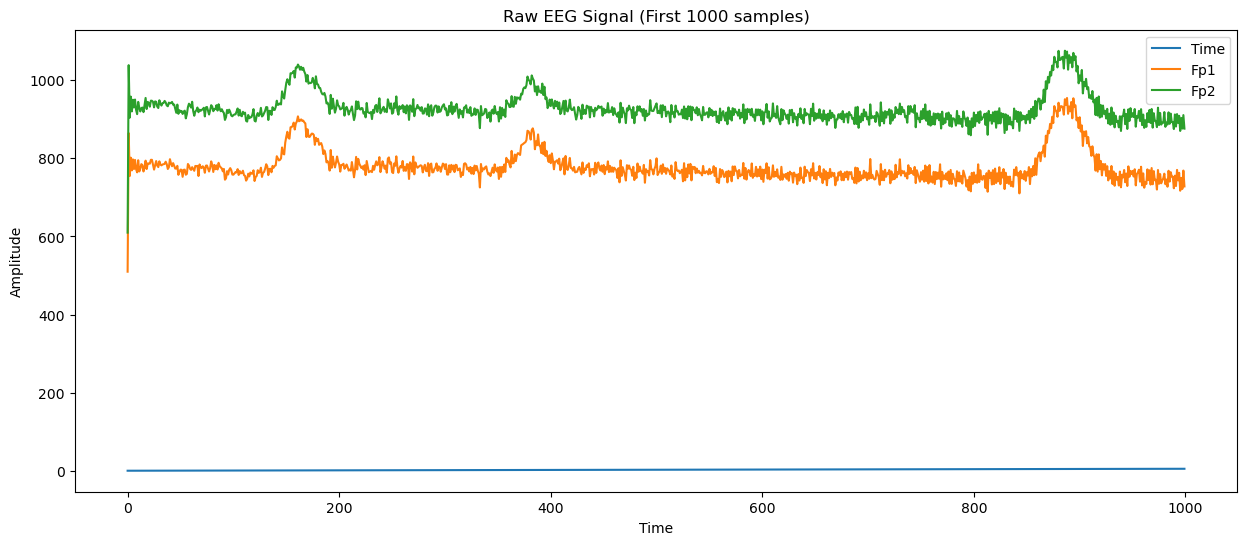

In [32]:
sample_file = os.listdir('dataset/train')[0]
df = pd.read_csv(f'dataset/train/{sample_file}')

eeg_channels = [col for col in df.columns if col not in ['FeedBackEvent', 'EOG']]

# Plot a few EEG channels
plt.figure(figsize=(15, 6))
for ch in eeg_channels[:3]:
    plt.plot(df[ch].values[:1000], label=ch)  # first 1000 samples
plt.title('Raw EEG Signal (First 1000 samples)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

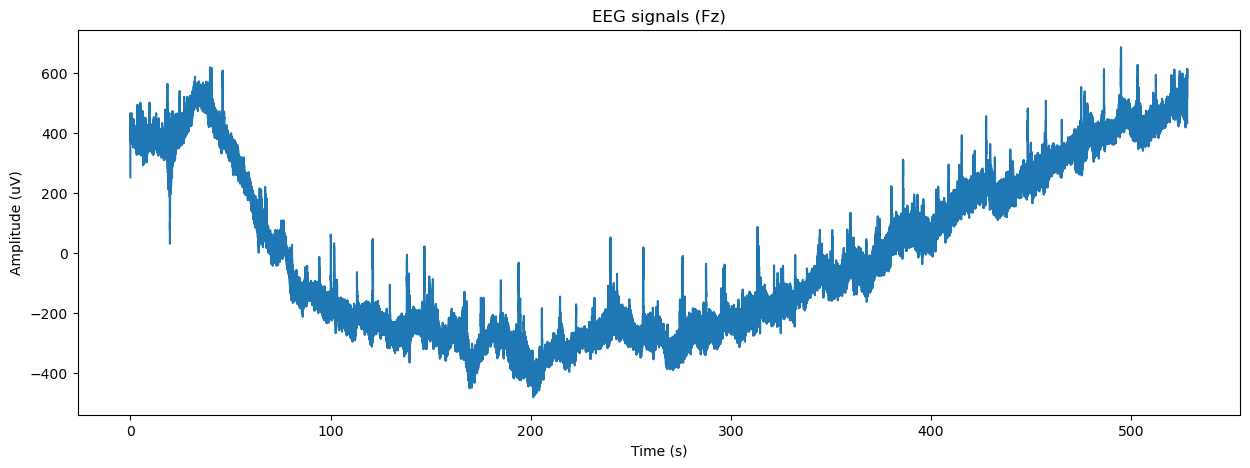

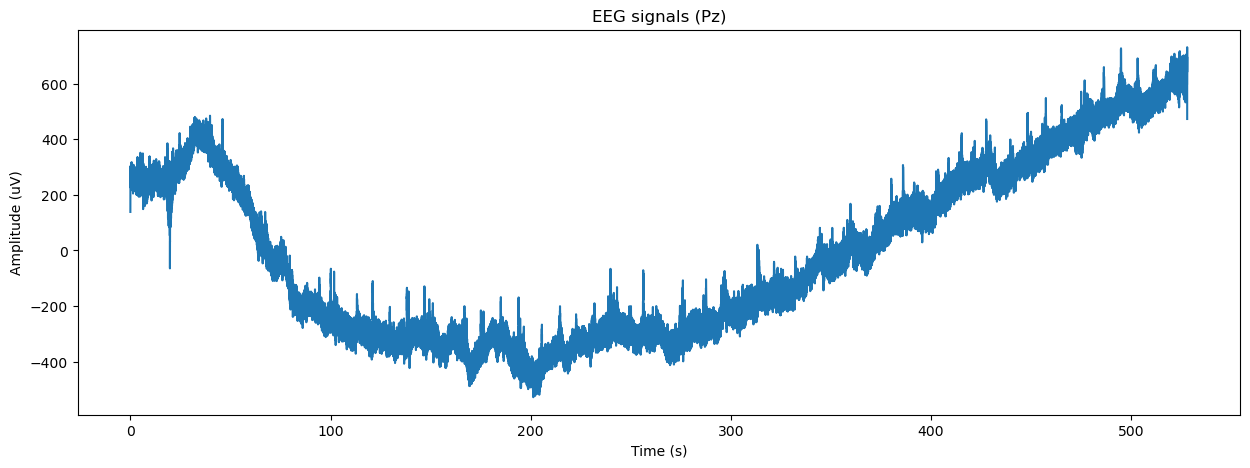

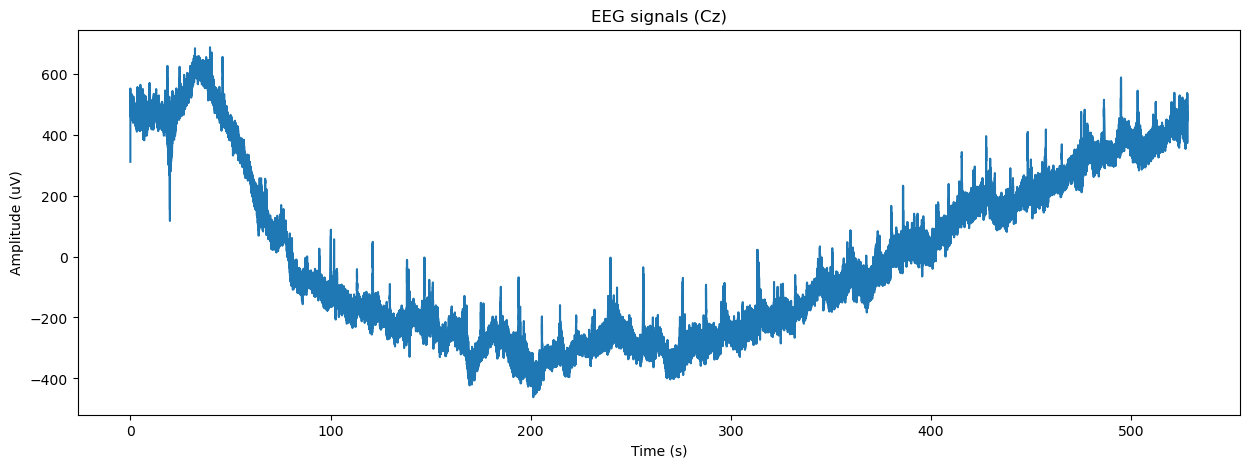

In [34]:
sample_file = pd.read_csv(os.path.join(data_path, session_files[0]))
sampling_rate = 250  # Hz
num_samples = len(sample_file['Fz'])
time_axis = np.arange(num_samples) / sampling_rate  # in seconds

plt.figure(figsize=(15, 5))
plt.plot(time_axis, sample_file['Fz'])
plt.title('EEG signals (Fz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(time_axis, sample_file['Pz'])
plt.title('EEG signals (Pz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(time_axis, sample_file['Cz'])
plt.title('EEG signals (Cz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

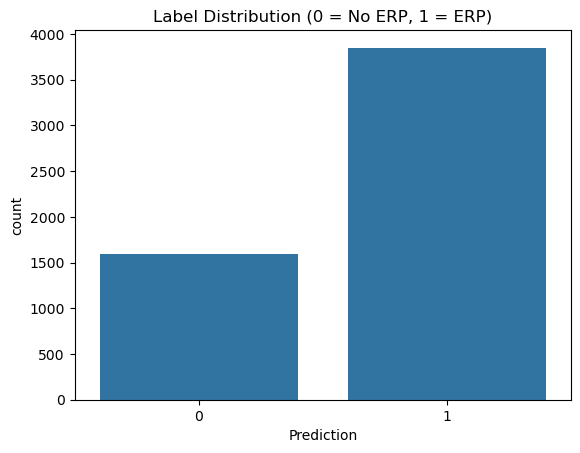

In [35]:
sns.countplot(x='Prediction', data=labels_df)
plt.title('Label Distribution (0 = No ERP, 1 = ERP)')
plt.show()


### Preprocessing: Butterworth + ICA

In [47]:
def filter(data): # Pass sampling rate as an argument
    # median filter to remove artifacts
    # data = signal.medfilt(data, kernel_size=3) # Uncomment if needed

    # --- High-Pass Filter ---
    hpf_cutoff = 1  # Hz - Recommended for ERPs to remove slow drift
    hpf_order = 4     # Filter order (can be same or different from LPF)

    # Design Butterworth HPF
    # Note: fs/2 is the Nyquist frequency
    b_high, a_high = signal.butter(hpf_order, hpf_cutoff / 100, btype='high')

    # Apply HPF using zero-phase filtering
    # Apply along the time axis (assuming channels x time or trials x channels x time)
    data_hpf = signal.filtfilt(b_high, a_high, data, axis=-1)

    # --- Low-Pass Filter ---
    lpf_cutoff = 40.0  # Hz - Typical for ERPs
    lpf_order = 4      # Filter order

    # Design Butterworth LPF
    b_low, a_low = signal.butter(lpf_order, lpf_cutoff / 100, btype='low')

    # Apply LPF using zero-phase filtering to the high-passed data
    filtered_data = signal.filtfilt(b_low, a_low, data_hpf, axis=-1)

    return filtered_data

In [2]:
eeg_channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
    'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
    'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
    'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7',
    'POz', 'P08', 'O1', 'O2']

eog_channel = 'EOG' 

all_channels = eeg_channels + [eog_channel]
all_labels = pd.read_csv('dataset/TrainLabels.csv').Prediction.values

try:
    all_epochs = np.load('all_epochs.npy')
except:
    all_epochs = [] # Store cleaned EEG epochs

    # --- Loop through sessions ---
    for filename in tqdm(os.listdir('train')):
        session_data = pd.read_csv(os.path.join('train', filename))

        # --- 1. Filter EEG and EOG Channels ---
        print(f"\nProcessing {filename}...")
        for id in all_channels:
            session_data[id] = filter(session_data[id].values)

        # --- 2. Prepare Continuous Data for ICA ---
        # Shape: (n_channels, n_timepoints)
        eeg_data = session_data[eeg_channels].values.T
        eog_data = session_data[eog_channel].values.reshape(1, -1) # Keep as 2D array

        # Transpose for sklearn: (n_timepoints, n_features)
        eeg_data_skl = eeg_data.T
        eog_data_skl = eog_data.T

        # --- 3. Standardize Data ---
        scaler_eeg = StandardScaler()
        eeg_data_scaled = scaler_eeg.fit_transform(eeg_data_skl)

        scaler_eog = StandardScaler()
        eog_data_scaled = scaler_eog.fit_transform(eog_data_skl) # Scale EOG separately

        # --- 4. Fit ICA on EEG Data ---
        n_components_ica = len(eeg_channels) # Use number of EEG channels as components
        ica = FastICA(n_components=n_components_ica,
                        random_state=42,
                        whiten='unit-variance', # Recommended for FastICA
                        max_iter=1000, # Increase iterations if convergence is an issue
                        tol=0.001)     # Convergence tolerance

        print("Fitting ICA...")
        sources_eeg = ica.fit_transform(eeg_data_scaled) # Shape: (n_timepoints, n_components_ica)
        print("ICA fitting complete.")

        # --- 5. Identify EOG Component(s) via Correlation ---
        print("Identifying EOG components...")
        correlations = []
        eog_signal_flat = eog_data_scaled.flatten() # Ensure EOG is 1D for correlation

        for i in range(sources_eeg.shape[1]):
            component_signal = sources_eeg[:, i]
            # Calculate Pearson correlation coefficient and p-value
            corr, _ = pearsonr(eog_signal_flat, component_signal)
            correlations.append(abs(corr)) # Use absolute correlation

            eog_component_index = np.argmax(correlations)
            max_corr = correlations[eog_component_index]

            print(f"Removing component {eog_component_index} with correlation: {max_corr:.4f}")
            sources_cleaned = sources_eeg.copy()
            sources_cleaned[:, eog_component_index] = 0

        # --- 7. Reconstruct Cleaned EEG Data ---
        print("Reconstructing cleaned EEG data...")
        # Use inverse_transform to go from sources back to sensor space
        eeg_data_cleaned_scaled = ica.inverse_transform(sources_cleaned)

        # --- 8. Un-standardize Cleaned EEG Data ---
        eeg_data_cleaned_unscaled = scaler_eeg.inverse_transform(eeg_data_cleaned_scaled)

        # Prepare cleaned data for epoching (back to DataFrame structure)
        eeg_data_to_epoch = pd.DataFrame(eeg_data_cleaned_unscaled, columns=eeg_channels, index=session_data.index)
        print("EEG data cleaned.")


        # --- 9. Epoching
        session_feedback_ids = session_data[session_data['FeedBackEvent'] == 1].index
        session_epochs = []
        print(f"Epoching {len(session_feedback_ids)} events...")
        for idx in session_feedback_ids:
            # Define epoch window relative to event index
            start_idx = idx - 40  # 200ms before (40 samples at 200Hz)
            end_idx = idx + 199 # 1000ms after (200 samples at 200Hz) -> inclusive index for .loc

            # Define baseline window relative to event index
            baseline_start_idx = idx - 40 # 200ms before
            baseline_end_idx = idx      # Up to (but not including) the event

            # Extract epoch data for EEG channels
            epoch_data = eeg_data_to_epoch.loc[start_idx:end_idx].copy()

            # Calculate baseline using the correct window from the *epoched* data
            baseline_data = epoch_data.loc[baseline_start_idx:baseline_end_idx]
            baseline_mean = baseline_data.mean(axis=0)

            # Apply baseline correction
            epoch_data -= baseline_mean

            # Append the baseline-corrected epoch (EEG channels only)
            session_epochs.append(epoch_data.values) # Append numpy array

        all_epochs.extend(session_epochs) # Add the cleaned epochs to the list
        print(f"Finished {filename}. Total epochs collected: {len(all_epochs)}")


    # --- Convert cleaned epochs to NumPy array ---
    # Shape: (n_epochs, n_timepoints_in_epoch, n_eeg_channels)
    all_epochs = np.array(all_epochs)
    print(f"Final shape of cleaned epochs array: {all_epochs.shape}")

In [3]:
epochs_train, epochs_test, y_train, y_test = train_test_split(all_epochs, all_labels, test_size=0.2, random_state=42)

### All data points
### Preprocessing: Butterworth + ICA

#### Original Unbalanced data

In [5]:
def compute_and_plot_roc_auc_heatmap(train_epochs, train_labels, eeg_channels, test_size=0.2, random_state=42):
    
    channel_to_roc = {}

    for id, channel in tqdm(enumerate(eeg_channels), desc="Processing channels"):
        # Extract data for this channel
        channel_data_train = np.array([epoch[:, id] for epoch in train_epochs])  # shape: (n_epochs, n_timepoints)

        rocs = []
        for time_point in range(channel_data_train.shape[1]):
            time_point_data = channel_data_train[:, time_point]
            try:
                roc = roc_auc_score(train_labels, time_point_data)
                rocs.append(roc)
            except ValueError:
                rocs.append(np.nan)  # Append NaN if AUC can't be computed

        channel_to_roc[channel] = rocs

    # Convert to 2D array for plotting
    arr = np.array([channel_to_roc[ch] for ch in eeg_channels])

    # Generate time labels (assuming 1200 timepoints from -200 to 1000 ms)
    time_labels = np.linspace(-200, 1000, arr.shape[1]).astype(int)

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(arr, cmap='jet', vmin=0.35, vmax=0.65)
    plt.xticks(np.arange(0, arr.shape[1], 5), time_labels[::5], rotation=90)
    plt.yticks(np.arange(0, len(eeg_channels)), eeg_channels, rotation=0)
    plt.xlabel('Time (ms)')
    plt.ylabel('Channels')
    plt.title('ROC AUC for each channel over time (Training Data)')
    plt.tight_layout()
    plt.show()

    return channel_to_roc


In [6]:
def build_dataset(epochs, channels, t_start, t_end, window_size):
    time_points = range((t_start + 200) // 5, (t_end + 200) // 5, window_size)
    X = []
    for id in tqdm(range(len(channels))):
        channel_data = [epoch[:, id] for epoch in epochs]  # shape: (n_epochs, n_timepoints)
        channel_data = np.array(channel_data)  # shape: (n_epochs, 240)

        for time_point in time_points:  # all time points from -200 to 1000 ms
            time_point_data = channel_data[:, time_point:time_point+window_size].mean(axis=1)  # shape: (n_epochs,)
            X.append(time_point_data)

    X = np.array(X).T  # shape: (n_samples, n_features)
    return X

In [7]:
def preprocess(X_train, X_test, apply_pca, n_components):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if not apply_pca:
        print("No PCA applied")
        return X_train_scaled, X_test_scaled
    
    pca = PCA(n_components)  # This will retain enough components to explain 95% of the variance
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"Applying PCA ({n_components if n_components else 1} variance, {pca.n_components_} components)")
    return X_train_pca, X_test_pca

In [8]:
def fit_models(X_train, X_test, y_train, y_test, apply_pca=False, n_components=0.95):
    X_train_pca, X_test_pca = preprocess(X_train, X_test, apply_pca, n_components)
    models = {
        "NCC": NCC(), 
        "LDA": LDA(), 
        "RLDA": LDA(solver='lsqr', shrinkage="auto"),
        "LogReg": LogisticRegression(max_iter=2000, random_state=42)
    }
    for name in models.keys():
        model = models[name]
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        print(f"    {name}: {f1_score(y_test, y_pred, average='macro'):.4f}")

In [9]:
def loop(X_train, X_test, y_train, y_test, try_no_pca=True):
    seqs = [(True, 0.95), (True, 0.99), (True, None)]
    if try_no_pca:
        seqs = [(False, None)] + seqs
    for apply_pca, n_components in seqs:
        fit_models(X_train, X_test, y_train, y_test, apply_pca=apply_pca, n_components=n_components)
        print()

Processing channels: 56it [01:04,  1.15s/it]


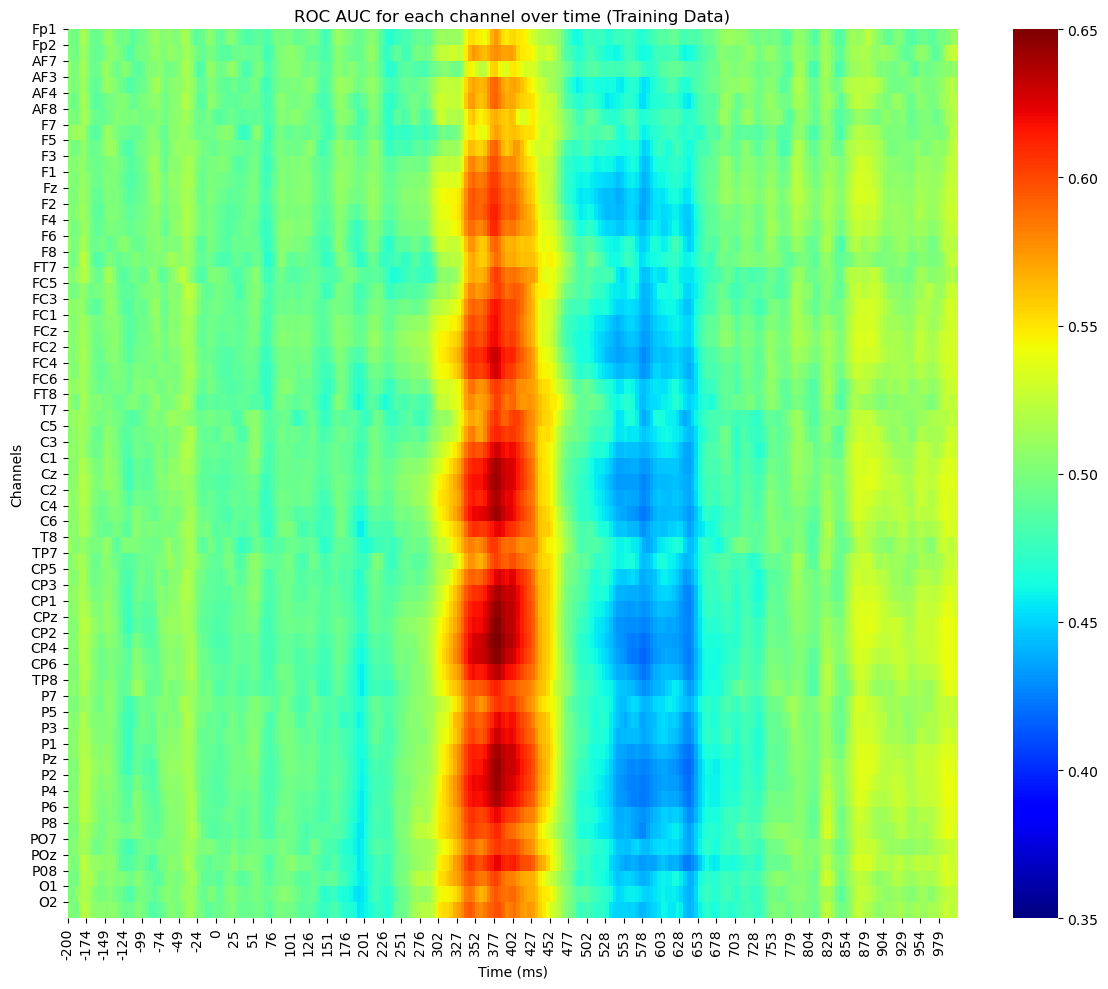

In [11]:
channel_to_roc = compute_and_plot_roc_auc_heatmap(epochs_train, y_train, eeg_channels)

In [29]:
X_train = build_dataset(epochs_train, eeg_channels, -200, 1000, 1)
X_test = build_dataset(epochs_test, eeg_channels, -200, 1000, 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 39.54it/s]


In [15]:
loop(X_train, X_test, y_train, y_test, try_no_pca=False)

Applying PCA (0.95 variance, 287 components)
    NCC: 0.5695
    LDA: 0.5692
    RLDA: 0.5414
    LogReg: 0.5521

Applying PCA (0.99 variance, 1079 components)
    NCC: 0.5690
    LDA: 0.6093
    RLDA: 0.5759
    LogReg: 0.6147

Applying PCA (1 variance, 4352 components)
    NCC: 0.5690
    LDA: 0.5017
    RLDA: 0.5196
    LogReg: 0.5926



C:\Users\LENOVO\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Balanced dataset by undersampling

In [44]:
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
print(X.shape, y.shape)

(5440, 3360) (5440,)


In [10]:
def balance_and_split(X, labels, test_size=0.2, random_state=42):
    # Step 1: Combine features and labels
    df = pd.DataFrame(X)
    df['label'] = labels

    # Step 2: Separate majority and minority classes
    class_0 = df[df['label'] == 0]
    class_1 = df[df['label'] == 1]

    # Step 3: Undersample the majority class (adjust if 1 is minority)
    if len(class_0) > len(class_1):
        class_majority = class_0
        class_minority = class_1
    else:
        class_majority = class_1
        class_minority = class_0

    class_majority_downsampled = resample(
        class_majority,
        replace=False,
        n_samples=len(class_minority),
        random_state=random_state
    )

    # Step 4: Combine and shuffle
    balanced_df = pd.concat([class_minority, class_majority_downsampled])
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Step 5: Split into features and labels
    X_balanced = balanced_df.drop('label', axis=1).values
    y_balanced = balanced_df['label'].values

    # Step 6: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=test_size, random_state=random_state
    )

    # Output
    print("Class distribution after balancing:", np.bincount(y_balanced))
    print("Training set shape:", X_train.shape)
    print("Test set shape:", X_test.shape)

    return X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test = balance_and_split(X, y)

Class distribution after balancing: [1590 1590]
Training set shape: (2544, 13440)
Test set shape: (636, 13440)


In [20]:
loop(X_train, X_test, y_train, y_test, try_no_pca=False)

Applying PCA (0.95 variance, 256 components)
    NCC: 0.6252
    LDA: 0.6382
    RLDA: 0.6398
    LogReg: 0.6536

Applying PCA (0.99 variance, 872 components)
    NCC: 0.6237
    LDA: 0.6651
    RLDA: 0.6635
    LogReg: 0.6647

Applying PCA (1 variance, 2544 components)
    NCC: 0.6237
    LDA: 0.4900
    RLDA: 0.6022
    LogReg: 0.6708



#### Balanced dataset by adjusting models' loss functions (only applicable for LDA, R-LDA, LR)

In [15]:
def fit_models_balanced(X_train, X_test, y_train, y_test, apply_pca=False, n_components=0.95):
    X_train_pca, X_test_pca = preprocess(X_train, X_test, apply_pca, n_components)
    
    models = {
        #"NCC": NCC(), 
        "LDA": LDA(priors=[0.5, 0.5]),  # Balanced class priors
        "RLDA": LDA(solver='lsqr', shrinkage="auto", priors=[0.5, 0.5]),  # Same
        "LogReg": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
    }
    
    for name, model in models.items():
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        print(f"    {name}: {f1_score(y_test, y_pred, average='macro'):.4f}")

In [12]:
def loop_balanced(X_train, X_test, y_train, y_test, try_no_pca=True):
    seqs = [(True, 0.95), (True, 0.99), (True, None)]
    if try_no_pca:
        seqs = [(False, None)] + seqs
    for apply_pca, n_components in seqs:
        fit_models_balanced(X_train, X_test, y_train, y_test, apply_pca=apply_pca, n_components=n_components)
        print()

In [22]:
X_train = build_dataset(epochs_train, eeg_channels, -200, 1000, 1)
X_test = build_dataset(epochs_test, eeg_channels, -200, 1000, 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 39.76it/s]


In [31]:
# Here LR: inerations = 1000
loop_balanced(X_train, X_test, y_train, y_test, try_no_pca=False)

Applying PCA (0.95 variance, 287 components)
    LDA: 0.5750
    RLDA: 0.5722
    LogReg: 0.5746

Applying PCA (0.99 variance, 1079 components)
    LDA: 0.6101
    RLDA: 0.6083
    LogReg: 0.6071

Applying PCA (1 variance, 4352 components)
    LDA: 0.5017
    RLDA: 0.5253
    LogReg: 0.5993



C:\Users\LENOVO\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
### Testing LR with iteration = 2000
loop_balanced(X_train, X_test, y_train, y_test, try_no_pca=False)

Applying PCA (0.95 variance, 287 components)
    LogReg: 0.5521

Applying PCA (0.99 variance, 1079 components)
    LogReg: 0.6147

Applying PCA (1 variance, 4352 components)
    LogReg: 0.5926



### Interval (not averaged)

#### Unbalanced dataset

##### Features from interval 300-450

In [38]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 450)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 450, 1)
X_test = build_dataset(epochs_test, eeg_channels, 300, 450, 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 93.06it/s]


In [39]:
loop(X_train, X_test, y_train, y_test)

No PCA applied
    NCC: 0.5618
    LDA: 0.6018
    RLDA: 0.6090
    LogReg: 0.6211

Applying PCA (0.95 variance, 41 components)
    NCC: 0.5618
    LDA: 0.5282
    RLDA: 0.5263
    LogReg: 0.5304

Applying PCA (0.99 variance, 208 components)
    NCC: 0.5618
    LDA: 0.5927
    RLDA: 0.5691
    LogReg: 0.5856

Applying PCA (1 variance, 1680 components)
    NCC: 0.5618
    LDA: 0.5961
    RLDA: 0.5789
    LogReg: 0.6245



##### Features from interval 300-450 and 500-650

In [40]:
time_points = list(range(300, 451)) + list(range(500, 651))
features = [f"{channel} voltage at {tp} ms" for channel in eeg_channels for tp in time_points]

X_train_1 = build_dataset(epochs_train, eeg_channels, 300, 450, 1)
X_train_2 = build_dataset(epochs_train, eeg_channels, 500, 650, 1)
X_train = np.concatenate([X_train_1, X_train_2], axis=1)

X_test_1 = build_dataset(epochs_test, eeg_channels, 300, 450, 1)
X_test_2 = build_dataset(epochs_test, eeg_channels, 500, 650, 1)
X_test = np.concatenate([X_test_1, X_test_2], axis=1)



100%|█████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 101.64it/s]


In [41]:
loop(X_train, X_test, y_train, y_test)

No PCA applied
    NCC: 0.5772
    LDA: 0.6073
    RLDA: 0.6146
    LogReg: 0.6020

Applying PCA (0.95 variance, 73 components)
    NCC: 0.5772
    LDA: 0.5550
    RLDA: 0.5478
    LogReg: 0.5610

Applying PCA (0.99 variance, 366 components)
    NCC: 0.5772
    LDA: 0.6109
    RLDA: 0.5982
    LogReg: 0.6087

Applying PCA (1 variance, 3360 components)
    NCC: 0.5772
    LDA: 0.5636
    RLDA: 0.5642
    LogReg: 0.6020



##### We will proceed with features only from 300-450 as additional 'probably' introduce noise

#### Balanced dataset (Undersampling)

In [49]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 450)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 450, 1)
X_test = build_dataset(epochs_test, eeg_channels, 300, 450, 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 78.69it/s]


In [54]:
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
print(X.shape, y.shape)

(5440, 1680) (5440,)


In [55]:
X_train, X_test, y_train, y_test = balance_and_split(X, y)

Class distribution after balancing: [1590 1590]
Training set shape: (2544, 1680)
Test set shape: (636, 1680)


In [56]:
loop(X_train, X_test, y_train, y_test)

No PCA applied
    NCC: 0.6100
    LDA: 0.6208
    RLDA: 0.6288
    LogReg: 0.6398

Applying PCA (0.95 variance, 39 components)
    NCC: 0.6100
    LDA: 0.6350
    RLDA: 0.6365
    LogReg: 0.6350

Applying PCA (0.99 variance, 193 components)
    NCC: 0.6100
    LDA: 0.6257
    RLDA: 0.6241
    LogReg: 0.6273

Applying PCA (1 variance, 1680 components)
    NCC: 0.6100
    LDA: 0.5928
    RLDA: 0.5988
    LogReg: 0.6398



#### Balanced dataset (loss function adj for LDA, R-LDA, LR)

In [13]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 450)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 450, 1)
X_test = build_dataset(epochs_test, eeg_channels, 300, 450, 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 88.36it/s]


In [16]:
loop_balanced(X_train, X_test, y_train, y_test)

No PCA applied
    LDA: 0.6001
    RLDA: 0.6103
    LogReg: 0.6192

Applying PCA (0.95 variance, 41 components)
    LDA: 0.5753
    RLDA: 0.5761
    LogReg: 0.5797

Applying PCA (0.99 variance, 208 components)
    LDA: 0.5892
    RLDA: 0.5943
    LogReg: 0.5944

Applying PCA (1 variance, 1680 components)
    LDA: 0.5943
    RLDA: 0.5813
    LogReg: 0.6192



### Windowed Interval

#### Unbalanced dataset

Let's make topographies

In [6]:
def compute_channel_time_roc(epochs, labels, eeg_channels, window_size=5, step=5, time_range=(0, 240)):
    """
    Computes ROC AUC scores for each EEG channel across time windows and plots a heatmap.
    
    Parameters:
        epochs (list of np.arrays): List of EEG epoch arrays with shape (timepoints, channels).
        labels (np.array): Corresponding labels (0/1) for each epoch.
        eeg_channels (list of str): Names of EEG channels.
        window_size (int): Number of time points per window.
        step (int): Step size to slide the window.
        time_range (tuple): Time window to evaluate over (start, end) in timepoints.
        
    Returns:
        channel_to_roc (dict): Dictionary mapping channel name to list of ROC AUC scores over time.
    """
    channel_to_roc = {}
    num_channels = len(eeg_channels)

    for idx, channel in tqdm(enumerate(eeg_channels), total=num_channels):
        channel_data = np.array([epoch[:, idx] for epoch in epochs])
        rocs = []

        for time_point in range(time_range[0], time_range[1], step):
            segment = channel_data[:, time_point:time_point+window_size].mean(axis=1)
            try:
                auc = roc_auc_score(labels, segment)
            except ValueError:
                auc = np.nan  # In case there's only one class in `labels`
            rocs.append(auc)

        channel_to_roc[channel] = rocs

    # Convert to array and plot heatmap
    arr = np.array([channel_to_roc[ch] for ch in eeg_channels])
    plt.figure(figsize=(12, 10))
    sns.heatmap(arr, cmap='jet', vmin=0.35, vmax=0.65)
    xtick_labels = np.arange(time_range[0], time_range[1] + 1, 20)
    xtick_pos = (xtick_labels - time_range[0]) // step
    plt.xticks(xtick_pos, xtick_labels * 5 - 200, rotation=90)  # adjust time offset here if needed
    plt.yticks(np.arange(num_channels), eeg_channels, rotation=0)
    plt.xlabel('Time (ms)')
    plt.ylabel('Channels')
    plt.title('ROC AUC for each channel over time')
    plt.show()

    return channel_to_roc


100%|██████████| 56/56 [00:04<00:00, 13.09it/s]


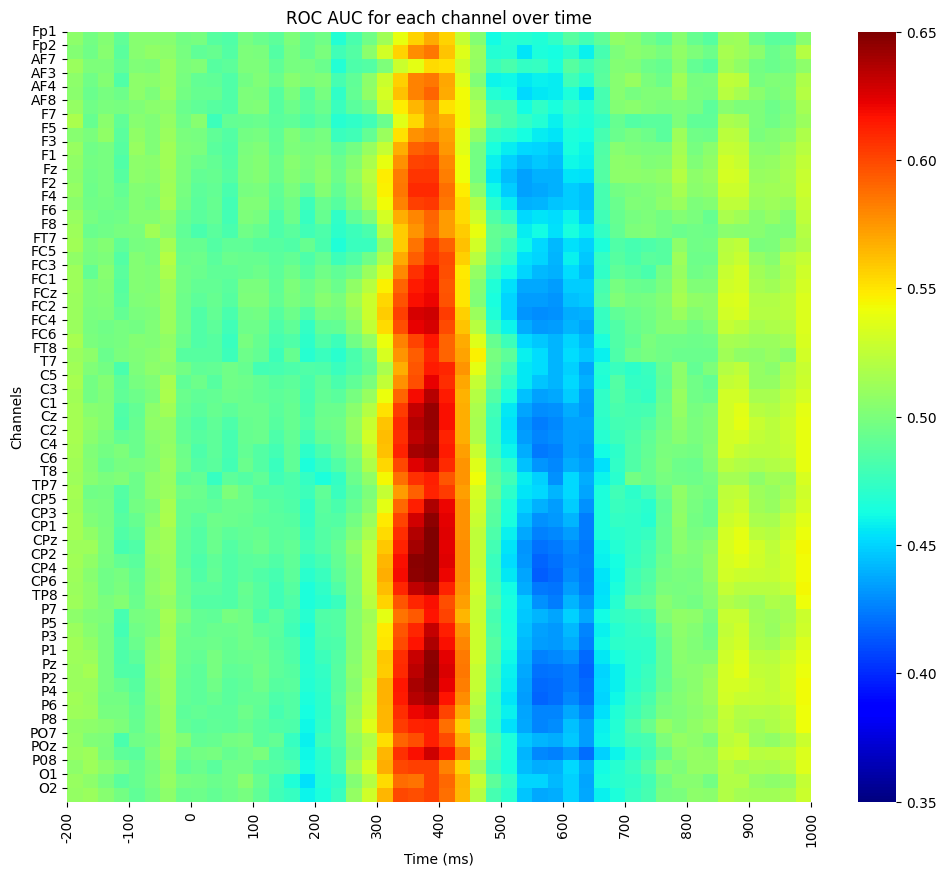

In [7]:
channel_to_roc = compute_channel_time_roc(epochs_train, y_train, eeg_channels)


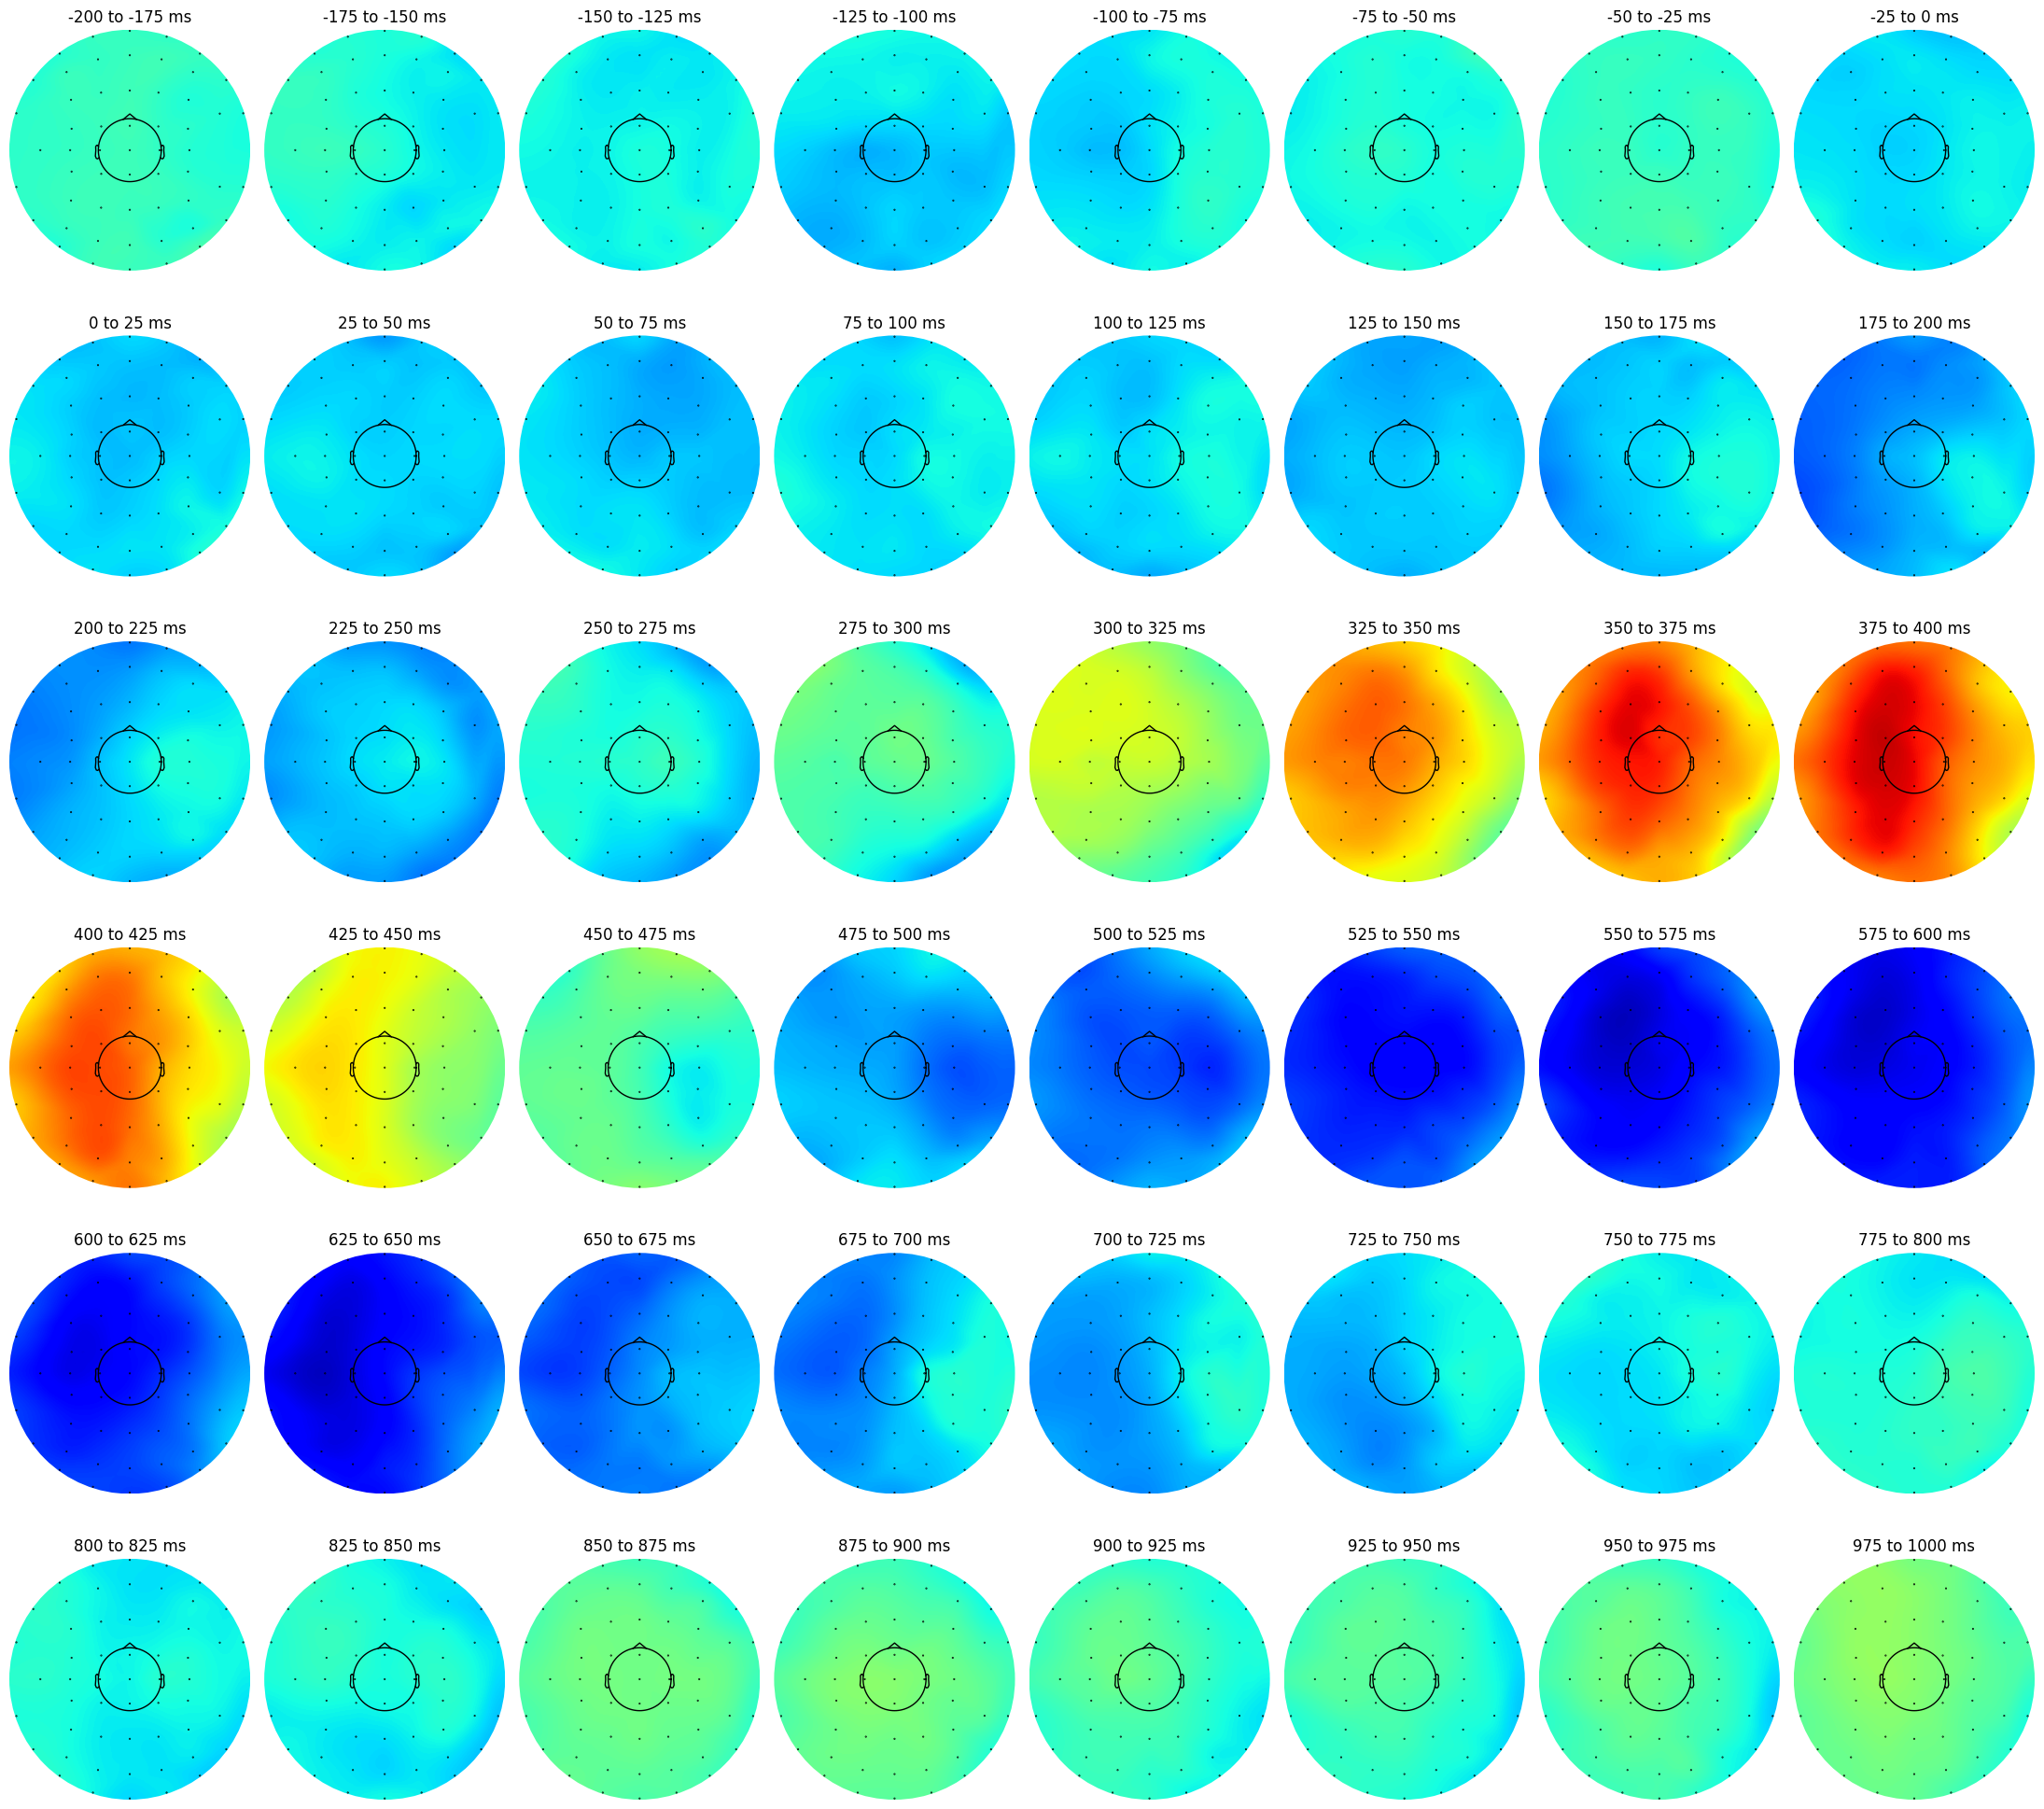

In [37]:
# Load CSV
df = pd.read_csv("ChannelsLocation.csv")
arr = np.array([channel_to_roc[ch] for ch in eeg_channels])

# Convert spherical (Radius, Phi) -> Cartesian (X, Y, Z)
df["Phi"] = np.deg2rad(df["Phi"])  # Convert degrees to radians
df["X"] = df["Radius"] * np.cos(df["Phi"])
df["Y"] = df["Radius"] * np.sin(df["Phi"])
df["Z"] = np.zeros(len(df))  # Assume all electrodes lie on a 2D plane

# Create Montage
ch_pos = {row["Labels"]: [row["X"], row["Y"], row["Z"]] for _, row in df.iterrows()}
montage = mne.channels.make_dig_montage(ch_pos, coord_frame="head")

# Create info object
ch_names = list(df["Labels"])
info = mne.create_info(ch_names, sfreq=200, ch_types="eeg")
info.set_montage(montage)

# Example: Plot Topomap with Random Data
f, ax = plt.subplots(6, 8, figsize=(22, 20))
ax = ax.ravel()

for i in range(0, 48):
    ax[i].set_title(f"{(i - 8)*25} to {(i - 7)*25} ms")
    mne.viz.plot_topomap(arr[:, i], info, size=3, cmap="jet", vlim=(0.4, 0.67), 
                        show=False, outlines="head", axes=ax[i], contours=False)

plt.tight_layout()
plt.show()

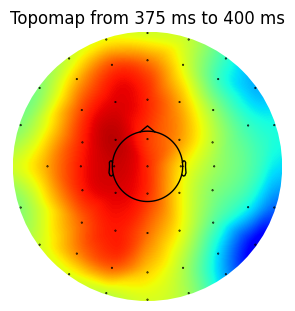

In [38]:
mne.viz.plot_topomap(arr[:, 23], info, size=3, cmap="jet", vlim=(0.54, 0.66), 
                    show=False, outlines="head", contours=False)
plt.title("Topomap from 375 ms to 400 ms")
plt.show()

In [19]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 450, 5)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 450, 5)
X_test = build_dataset(epochs_test, eeg_channels, 300, 450, 5)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 94.78it/s]


In [20]:
loop(X_train, X_test, y_train, y_test)

No PCA applied
    NCC: 0.5660
    LDA: 0.6262
    RLDA: 0.5750
    LogReg: 0.6310

Applying PCA (0.95 variance, 16 components)
    NCC: 0.5645
    LDA: 0.5154
    RLDA: 0.5046
    LogReg: 0.5142

Applying PCA (0.99 variance, 66 components)
    NCC: 0.5660
    LDA: 0.5731
    RLDA: 0.5637
    LogReg: 0.5747

Applying PCA (1 variance, 336 components)
    NCC: 0.5660
    LDA: 0.6262
    RLDA: 0.6196
    LogReg: 0.6310



#### Balanced dataset (Undersampling)

In [21]:
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
print(X.shape, y.shape)

(5440, 336) (5440,)


In [22]:
X_train, X_test, y_train, y_test = balance_and_split(X, y)

Class distribution after balancing: [1590 1590]
Training set shape: (2544, 336)
Test set shape: (636, 336)


In [23]:
loop(X_train, X_test, y_train, y_test)

No PCA applied
    NCC: 0.6115
    LDA: 0.6523
    RLDA: 0.6492
    LogReg: 0.6572

Applying PCA (0.95 variance, 15 components)
    NCC: 0.6084
    LDA: 0.6195
    RLDA: 0.6132
    LogReg: 0.6164

Applying PCA (0.99 variance, 62 components)
    NCC: 0.6115
    LDA: 0.6570
    RLDA: 0.6554
    LogReg: 0.6634

Applying PCA (1 variance, 336 components)
    NCC: 0.6115
    LDA: 0.6523
    RLDA: 0.6506
    LogReg: 0.6572



#### Balanced Dataset (Adj loss function for LDA, R-LDA, LR)

In [27]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 450, 5)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 450, 5)
X_test = build_dataset(epochs_test, eeg_channels, 300, 450, 5)

100%|█████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 112.65it/s]


In [28]:
loop_balanced(X_train, X_test, y_train, y_test)

No PCA applied
    LDA: 0.6114
    RLDA: 0.6145
    LogReg: 0.6266

Applying PCA (0.95 variance, 16 components)
    LDA: 0.5740
    RLDA: 0.5720
    LogReg: 0.5755

Applying PCA (0.99 variance, 66 components)
    LDA: 0.5969
    RLDA: 0.5952
    LogReg: 0.6035

Applying PCA (1 variance, 336 components)
    LDA: 0.6114
    RLDA: 0.6080
    LogReg: 0.6261



### Checking effects of preprocessing: 
### We will compare the performance of using only butterworth filter vs butterworth + ICA

The results below are from using only butterworth filter (witohut ICA)

#### Apply only butterworth filter

In [49]:
eeg_channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
    'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
    'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
    'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7',
    'POz', 'P08', 'O1', 'O2']
eog_channel = 'EOG'
all_channels = eeg_channels + [eog_channel]

# Load labels
all_labels = pd.read_csv('dataset/TrainLabels.csv').Prediction.values

# Load or generate epochs
try:
    all_epochs = np.load('all_epochs_bw.npy')
except:
    all_epochs = []

    for filename in tqdm(os.listdir('dataset/train')):
        session_data = pd.read_csv(os.path.join('dataset/train', filename))

        print(f"\nProcessing {filename}...")

        # --- Filter EEG and EOG channels ---
        for ch in all_channels:
            session_data[ch] = filter(session_data[ch].values)  # Assume 'filter' is defined

        # Get EEG data
        eeg_data_to_epoch = session_data[eeg_channels]

        # --- Epoching ---
        session_feedback_ids = session_data[session_data['FeedBackEvent'] == 1].index
        session_epochs = []
        print(f"Epoching {len(session_feedback_ids)} events...")

        for idx in session_feedback_ids:
            start_idx = idx - 40  # 200ms before
            end_idx = idx + 199   # 1000ms after

            baseline_start_idx = idx - 40
            baseline_end_idx = idx

            # Extract epoch data
            epoch_data = eeg_data_to_epoch.loc[start_idx:end_idx].copy()

            # Extract and subtract baseline
            baseline_data = epoch_data.loc[baseline_start_idx:baseline_end_idx]
            baseline_mean = baseline_data.mean(axis=0)
            epoch_data -= baseline_mean

            session_epochs.append(epoch_data.values)

        all_epochs.extend(session_epochs)
        print(f"Finished {filename}. Total epochs collected: {len(all_epochs)}")

    # Convert to NumPy array
    all_epochs = np.array(all_epochs)
    print(f"Final shape of cleaned epochs array: {all_epochs.shape}")


  0%|                                                                                           | 0/80 [00:00<?, ?it/s]


Processing Data_S02_Sess01.csv...
Epoching 60 events...


  1%|█                                                                                  | 1/80 [00:05<07:16,  5.53s/it]

Finished Data_S02_Sess01.csv. Total epochs collected: 60

Processing Data_S02_Sess02.csv...
Epoching 60 events...


  2%|██                                                                                 | 2/80 [00:10<06:35,  5.07s/it]

Finished Data_S02_Sess02.csv. Total epochs collected: 120

Processing Data_S02_Sess03.csv...


  4%|███                                                                                | 3/80 [00:14<06:08,  4.79s/it]

Epoching 60 events...
Finished Data_S02_Sess03.csv. Total epochs collected: 180

Processing Data_S02_Sess04.csv...
Epoching 60 events...


  5%|████▏                                                                              | 4/80 [00:18<05:48,  4.58s/it]

Finished Data_S02_Sess04.csv. Total epochs collected: 240

Processing Data_S02_Sess05.csv...
Epoching 100 events...


  6%|█████▏                                                                             | 5/80 [00:25<06:31,  5.22s/it]

Finished Data_S02_Sess05.csv. Total epochs collected: 340

Processing Data_S06_Sess01.csv...
Epoching 60 events...


  8%|██████▏                                                                            | 6/80 [00:29<05:56,  4.81s/it]

Finished Data_S06_Sess01.csv. Total epochs collected: 400

Processing Data_S06_Sess02.csv...
Epoching 60 events...


  9%|███████▎                                                                           | 7/80 [00:33<05:36,  4.62s/it]

Finished Data_S06_Sess02.csv. Total epochs collected: 460

Processing Data_S06_Sess03.csv...
Epoching 60 events...


 10%|████████▎                                                                          | 8/80 [00:38<05:29,  4.58s/it]

Finished Data_S06_Sess03.csv. Total epochs collected: 520

Processing Data_S06_Sess04.csv...
Epoching 60 events...


 11%|█████████▎                                                                         | 9/80 [00:41<05:07,  4.33s/it]

Finished Data_S06_Sess04.csv. Total epochs collected: 580

Processing Data_S06_Sess05.csv...
Epoching 100 events...


 12%|██████████▎                                                                       | 10/80 [00:47<05:36,  4.81s/it]

Finished Data_S06_Sess05.csv. Total epochs collected: 680

Processing Data_S07_Sess01.csv...
Epoching 60 events...


 14%|███████████▎                                                                      | 11/80 [00:51<05:18,  4.62s/it]

Finished Data_S07_Sess01.csv. Total epochs collected: 740

Processing Data_S07_Sess02.csv...


 15%|████████████▎                                                                     | 12/80 [00:56<05:04,  4.48s/it]

Epoching 60 events...
Finished Data_S07_Sess02.csv. Total epochs collected: 800

Processing Data_S07_Sess03.csv...
Epoching 60 events...


 16%|█████████████▎                                                                    | 13/80 [01:00<04:59,  4.47s/it]

Finished Data_S07_Sess03.csv. Total epochs collected: 860

Processing Data_S07_Sess04.csv...
Epoching 60 events...


 18%|██████████████▎                                                                   | 14/80 [01:04<04:51,  4.42s/it]

Finished Data_S07_Sess04.csv. Total epochs collected: 920

Processing Data_S07_Sess05.csv...
Epoching 100 events...


 19%|███████████████▍                                                                  | 15/80 [01:11<05:28,  5.05s/it]

Finished Data_S07_Sess05.csv. Total epochs collected: 1020

Processing Data_S11_Sess01.csv...
Epoching 60 events...


 20%|████████████████▍                                                                 | 16/80 [01:15<05:13,  4.90s/it]

Finished Data_S11_Sess01.csv. Total epochs collected: 1080

Processing Data_S11_Sess02.csv...
Epoching 60 events...


 21%|█████████████████▍                                                                | 17/80 [01:20<05:06,  4.86s/it]

Finished Data_S11_Sess02.csv. Total epochs collected: 1140

Processing Data_S11_Sess03.csv...
Epoching 60 events...


 22%|██████████████████▍                                                               | 18/80 [01:25<05:06,  4.94s/it]

Finished Data_S11_Sess03.csv. Total epochs collected: 1200

Processing Data_S11_Sess04.csv...
Epoching 60 events...


 24%|███████████████████▍                                                              | 19/80 [01:30<05:03,  4.98s/it]

Finished Data_S11_Sess04.csv. Total epochs collected: 1260

Processing Data_S11_Sess05.csv...
Epoching 100 events...


 25%|████████████████████▌                                                             | 20/80 [01:38<05:42,  5.71s/it]

Finished Data_S11_Sess05.csv. Total epochs collected: 1360

Processing Data_S12_Sess01.csv...
Epoching 60 events...


 26%|█████████████████████▌                                                            | 21/80 [01:43<05:32,  5.64s/it]

Finished Data_S12_Sess01.csv. Total epochs collected: 1420

Processing Data_S12_Sess02.csv...
Epoching 60 events...


 28%|██████████████████████▌                                                           | 22/80 [01:48<05:19,  5.50s/it]

Finished Data_S12_Sess02.csv. Total epochs collected: 1480

Processing Data_S12_Sess03.csv...
Epoching 60 events...


 29%|███████████████████████▌                                                          | 23/80 [01:53<05:04,  5.34s/it]

Finished Data_S12_Sess03.csv. Total epochs collected: 1540

Processing Data_S12_Sess04.csv...
Epoching 60 events...


 30%|████████████████████████▌                                                         | 24/80 [01:58<04:43,  5.06s/it]

Finished Data_S12_Sess04.csv. Total epochs collected: 1600

Processing Data_S12_Sess05.csv...
Epoching 100 events...


 31%|█████████████████████████▋                                                        | 25/80 [02:06<05:21,  5.85s/it]

Finished Data_S12_Sess05.csv. Total epochs collected: 1700

Processing Data_S13_Sess01.csv...
Epoching 60 events...


 32%|██████████████████████████▋                                                       | 26/80 [02:10<05:01,  5.58s/it]

Finished Data_S13_Sess01.csv. Total epochs collected: 1760

Processing Data_S13_Sess02.csv...
Epoching 60 events...


 34%|███████████████████████████▋                                                      | 27/80 [02:15<04:46,  5.41s/it]

Finished Data_S13_Sess02.csv. Total epochs collected: 1820

Processing Data_S13_Sess03.csv...
Epoching 60 events...


 35%|████████████████████████████▋                                                     | 28/80 [02:20<04:34,  5.29s/it]

Finished Data_S13_Sess03.csv. Total epochs collected: 1880

Processing Data_S13_Sess04.csv...
Epoching 60 events...


 36%|█████████████████████████████▋                                                    | 29/80 [02:25<04:24,  5.19s/it]

Finished Data_S13_Sess04.csv. Total epochs collected: 1940

Processing Data_S13_Sess05.csv...
Epoching 100 events...


 38%|██████████████████████████████▊                                                   | 30/80 [02:33<04:58,  5.98s/it]

Finished Data_S13_Sess05.csv. Total epochs collected: 2040

Processing Data_S14_Sess01.csv...
Epoching 60 events...


 39%|███████████████████████████████▊                                                  | 31/80 [02:38<04:36,  5.64s/it]

Finished Data_S14_Sess01.csv. Total epochs collected: 2100

Processing Data_S14_Sess02.csv...
Epoching 60 events...


 40%|████████████████████████████████▊                                                 | 32/80 [02:43<04:19,  5.41s/it]

Finished Data_S14_Sess02.csv. Total epochs collected: 2160

Processing Data_S14_Sess03.csv...
Epoching 60 events...


 41%|█████████████████████████████████▊                                                | 33/80 [02:48<04:07,  5.28s/it]

Finished Data_S14_Sess03.csv. Total epochs collected: 2220

Processing Data_S14_Sess04.csv...


 42%|██████████████████████████████████▊                                               | 34/80 [02:53<04:00,  5.23s/it]

Epoching 60 events...
Finished Data_S14_Sess04.csv. Total epochs collected: 2280

Processing Data_S14_Sess05.csv...
Epoching 100 events...


 44%|███████████████████████████████████▉                                              | 35/80 [03:01<04:26,  5.91s/it]

Finished Data_S14_Sess05.csv. Total epochs collected: 2380

Processing Data_S16_Sess01.csv...
Epoching 60 events...


 45%|████████████████████████████████████▉                                             | 36/80 [03:06<04:07,  5.62s/it]

Finished Data_S16_Sess01.csv. Total epochs collected: 2440

Processing Data_S16_Sess02.csv...


 46%|█████████████████████████████████████▉                                            | 37/80 [03:11<03:58,  5.54s/it]

Epoching 60 events...
Finished Data_S16_Sess02.csv. Total epochs collected: 2500

Processing Data_S16_Sess03.csv...
Epoching 60 events...


 48%|██████████████████████████████████████▉                                           | 38/80 [03:16<03:47,  5.41s/it]

Finished Data_S16_Sess03.csv. Total epochs collected: 2560

Processing Data_S16_Sess04.csv...
Epoching 60 events...


 49%|███████████████████████████████████████▉                                          | 39/80 [03:21<03:35,  5.26s/it]

Finished Data_S16_Sess04.csv. Total epochs collected: 2620

Processing Data_S16_Sess05.csv...
Epoching 100 events...


 50%|█████████████████████████████████████████                                         | 40/80 [03:28<03:55,  5.88s/it]

Finished Data_S16_Sess05.csv. Total epochs collected: 2720

Processing Data_S17_Sess01.csv...


 51%|██████████████████████████████████████████                                        | 41/80 [03:34<03:50,  5.91s/it]

Epoching 60 events...
Finished Data_S17_Sess01.csv. Total epochs collected: 2780

Processing Data_S17_Sess02.csv...


 52%|███████████████████████████████████████████                                       | 42/80 [03:39<03:37,  5.73s/it]

Epoching 60 events...
Finished Data_S17_Sess02.csv. Total epochs collected: 2840

Processing Data_S17_Sess03.csv...
Epoching 60 events...


 54%|████████████████████████████████████████████                                      | 43/80 [03:45<03:29,  5.67s/it]

Finished Data_S17_Sess03.csv. Total epochs collected: 2900

Processing Data_S17_Sess04.csv...
Epoching 60 events...


 55%|█████████████████████████████████████████████                                     | 44/80 [03:51<03:22,  5.63s/it]

Finished Data_S17_Sess04.csv. Total epochs collected: 2960

Processing Data_S17_Sess05.csv...
Epoching 100 events...


 56%|██████████████████████████████████████████████▏                                   | 45/80 [03:58<03:41,  6.32s/it]

Finished Data_S17_Sess05.csv. Total epochs collected: 3060

Processing Data_S18_Sess01.csv...
Epoching 60 events...


 57%|███████████████████████████████████████████████▏                                  | 46/80 [04:04<03:26,  6.07s/it]

Finished Data_S18_Sess01.csv. Total epochs collected: 3120

Processing Data_S18_Sess02.csv...
Epoching 60 events...


 59%|████████████████████████████████████████████████▏                                 | 47/80 [04:10<03:15,  5.92s/it]

Finished Data_S18_Sess02.csv. Total epochs collected: 3180

Processing Data_S18_Sess03.csv...
Epoching 60 events...


 60%|█████████████████████████████████████████████████▏                                | 48/80 [04:15<03:01,  5.67s/it]

Finished Data_S18_Sess03.csv. Total epochs collected: 3240

Processing Data_S18_Sess04.csv...
Epoching 60 events...


 61%|██████████████████████████████████████████████████▏                               | 49/80 [04:20<02:52,  5.56s/it]

Finished Data_S18_Sess04.csv. Total epochs collected: 3300

Processing Data_S18_Sess05.csv...
Epoching 100 events...


 62%|███████████████████████████████████████████████████▎                              | 50/80 [04:29<03:14,  6.49s/it]

Finished Data_S18_Sess05.csv. Total epochs collected: 3400

Processing Data_S20_Sess01.csv...


 64%|████████████████████████████████████████████████████▎                             | 51/80 [04:34<02:58,  6.17s/it]

Epoching 60 events...
Finished Data_S20_Sess01.csv. Total epochs collected: 3460

Processing Data_S20_Sess02.csv...
Epoching 60 events...


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [04:39<02:44,  5.88s/it]

Finished Data_S20_Sess02.csv. Total epochs collected: 3520

Processing Data_S20_Sess03.csv...
Epoching 60 events...


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [04:44<02:33,  5.68s/it]

Finished Data_S20_Sess03.csv. Total epochs collected: 3580

Processing Data_S20_Sess04.csv...
Epoching 60 events...


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [04:49<02:21,  5.43s/it]

Finished Data_S20_Sess04.csv. Total epochs collected: 3640

Processing Data_S20_Sess05.csv...
Epoching 100 events...


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [04:57<02:34,  6.17s/it]

Finished Data_S20_Sess05.csv. Total epochs collected: 3740

Processing Data_S21_Sess01.csv...
Epoching 60 events...


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [05:02<02:20,  5.85s/it]

Finished Data_S21_Sess01.csv. Total epochs collected: 3800

Processing Data_S21_Sess02.csv...
Epoching 60 events...


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [05:07<02:09,  5.62s/it]

Finished Data_S21_Sess02.csv. Total epochs collected: 3860

Processing Data_S21_Sess03.csv...
Epoching 60 events...


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [05:13<02:03,  5.61s/it]

Finished Data_S21_Sess03.csv. Total epochs collected: 3920

Processing Data_S21_Sess04.csv...
Epoching 60 events...


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [05:18<01:56,  5.56s/it]

Finished Data_S21_Sess04.csv. Total epochs collected: 3980

Processing Data_S21_Sess05.csv...
Epoching 100 events...


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [05:27<02:06,  6.34s/it]

Finished Data_S21_Sess05.csv. Total epochs collected: 4080

Processing Data_S22_Sess01.csv...
Epoching 60 events...


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [05:32<01:54,  6.05s/it]

Finished Data_S22_Sess01.csv. Total epochs collected: 4140

Processing Data_S22_Sess02.csv...
Epoching 60 events...


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [05:37<01:44,  5.82s/it]

Finished Data_S22_Sess02.csv. Total epochs collected: 4200

Processing Data_S22_Sess03.csv...
Epoching 60 events...


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [05:42<01:36,  5.66s/it]

Finished Data_S22_Sess03.csv. Total epochs collected: 4260

Processing Data_S22_Sess04.csv...
Epoching 60 events...


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [05:48<01:28,  5.54s/it]

Finished Data_S22_Sess04.csv. Total epochs collected: 4320

Processing Data_S22_Sess05.csv...
Epoching 100 events...


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [05:55<01:32,  6.19s/it]

Finished Data_S22_Sess05.csv. Total epochs collected: 4420

Processing Data_S23_Sess01.csv...
Epoching 60 events...


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [06:01<01:25,  6.12s/it]

Finished Data_S23_Sess01.csv. Total epochs collected: 4480

Processing Data_S23_Sess02.csv...
Epoching 60 events...


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [06:07<01:16,  5.91s/it]

Finished Data_S23_Sess02.csv. Total epochs collected: 4540

Processing Data_S23_Sess03.csv...
Epoching 60 events...


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [06:12<01:08,  5.71s/it]

Finished Data_S23_Sess03.csv. Total epochs collected: 4600

Processing Data_S23_Sess04.csv...
Epoching 60 events...


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [06:17<01:01,  5.60s/it]

Finished Data_S23_Sess04.csv. Total epochs collected: 4660

Processing Data_S23_Sess05.csv...
Epoching 100 events...


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [06:26<01:03,  6.39s/it]

Finished Data_S23_Sess05.csv. Total epochs collected: 4760

Processing Data_S24_Sess01.csv...


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [06:31<00:54,  6.10s/it]

Epoching 60 events...
Finished Data_S24_Sess01.csv. Total epochs collected: 4820

Processing Data_S24_Sess02.csv...


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [06:37<00:47,  5.91s/it]

Epoching 60 events...
Finished Data_S24_Sess02.csv. Total epochs collected: 4880

Processing Data_S24_Sess03.csv...


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [06:42<00:40,  5.83s/it]

Epoching 60 events...
Finished Data_S24_Sess03.csv. Total epochs collected: 4940

Processing Data_S24_Sess04.csv...
Epoching 60 events...


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [06:48<00:35,  5.83s/it]

Finished Data_S24_Sess04.csv. Total epochs collected: 5000

Processing Data_S24_Sess05.csv...
Epoching 100 events...


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [06:56<00:32,  6.53s/it]

Finished Data_S24_Sess05.csv. Total epochs collected: 5100

Processing Data_S26_Sess01.csv...
Epoching 60 events...


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [07:02<00:24,  6.20s/it]

Finished Data_S26_Sess01.csv. Total epochs collected: 5160

Processing Data_S26_Sess02.csv...
Epoching 60 events...


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [07:07<00:18,  6.07s/it]

Finished Data_S26_Sess02.csv. Total epochs collected: 5220

Processing Data_S26_Sess03.csv...
Epoching 60 events...


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [07:13<00:12,  6.07s/it]

Finished Data_S26_Sess03.csv. Total epochs collected: 5280

Processing Data_S26_Sess04.csv...
Epoching 60 events...


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [07:19<00:06,  6.02s/it]

Finished Data_S26_Sess04.csv. Total epochs collected: 5340

Processing Data_S26_Sess05.csv...
Epoching 100 events...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [07:29<00:00,  5.61s/it]

Finished Data_S26_Sess05.csv. Total epochs collected: 5440


Final shape of cleaned epochs array: (5440, 240, 56)


In [64]:
epochs_train, epochs_test, y_train, y_test = train_test_split(all_epochs, all_labels, test_size=0.2, random_state=42)

#### Interval (not averaged) 

##### Balanced dataset (undersampling)

In [51]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 450)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 450, 1)
X_test = build_dataset(epochs_test, eeg_channels, 300, 450, 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 97.49it/s]


In [52]:
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
print(X.shape, y.shape)

(5440, 1680) (5440,)


In [53]:
X_train, X_test, y_train, y_test = balance_and_split(X, y)

Class distribution after balancing: [1590 1590]
Training set shape: (2544, 1680)
Test set shape: (636, 1680)


In [54]:
loop(X_train, X_test, y_train, y_test, try_no_pca=False)

Applying PCA (0.95 variance, 23 components)
    NCC: 0.5813
    LDA: 0.6318
    RLDA: 0.6303
    LogReg: 0.6319

Applying PCA (0.99 variance, 130 components)
    NCC: 0.5814
    LDA: 0.6462
    RLDA: 0.6477
    LogReg: 0.6478

Applying PCA (1 variance, 1680 components)
    NCC: 0.5814
    LDA: 0.5927
    RLDA: 0.5848
    LogReg: 0.6272



##### Balanced dataset (loss function)

In [57]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 450)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 450, 1)
X_test = build_dataset(epochs_test, eeg_channels, 300, 450, 1)

100%|█████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 100.49it/s]


In [58]:
loop_balanced(X_train, X_test, y_train, y_test)

No PCA applied
    LDA: 0.6016
    RLDA: 0.6235
    LogReg: 0.6192

Applying PCA (0.95 variance, 23 components)
    LDA: 0.5676
    RLDA: 0.5651
    LogReg: 0.5633

Applying PCA (0.99 variance, 135 components)
    LDA: 0.6012
    RLDA: 0.5992
    LogReg: 0.6028

Applying PCA (1 variance, 1680 components)
    LDA: 0.5743
    RLDA: 0.5821
    LogReg: 0.6205



#### Windowed interval

##### Balanced dataset (undersampling)

In [59]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 450, 5)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 450, 5)
X_test = build_dataset(epochs_test, eeg_channels, 300, 450, 5)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 96.33it/s]


In [60]:
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
print(X.shape, y.shape)

(5440, 336) (5440,)


In [61]:
X_train, X_test, y_train, y_test = balance_and_split(X, y)

Class distribution after balancing: [1590 1590]
Training set shape: (2544, 336)
Test set shape: (636, 336)


In [62]:
loop(X_train, X_test, y_train, y_test, try_no_pca=False)

Applying PCA (0.95 variance, 11 components)
    NCC: 0.5799
    LDA: 0.6335
    RLDA: 0.6367
    LogReg: 0.6335

Applying PCA (0.99 variance, 40 components)
    NCC: 0.5783
    LDA: 0.6667
    RLDA: 0.6635
    LogReg: 0.6667

Applying PCA (1 variance, 336 components)
    NCC: 0.5799
    LDA: 0.6556
    RLDA: 0.6556
    LogReg: 0.6777



##### Balanced dataset (loss function)

In [63]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 450, 5)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 450, 5)
X_test = build_dataset(epochs_test, eeg_channels, 300, 450, 5)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 96.53it/s]


In [65]:
loop_balanced(X_train, X_test, y_train, y_test)

No PCA applied
    LDA: 0.6196
    RLDA: 0.6147
    LogReg: 0.6347

Applying PCA (0.95 variance, 11 components)
    LDA: 0.5672
    RLDA: 0.5659
    LogReg: 0.5642

Applying PCA (0.99 variance, 42 components)
    LDA: 0.6066
    RLDA: 0.6089
    LogReg: 0.6058

Applying PCA (1 variance, 336 components)
    LDA: 0.6196
    RLDA: 0.6204
    LogReg: 0.6360

